In [86]:
import torch
from torch import nn
from typing import List
import matplotlib.pyplot as plt
from tqdm import tqdm

In [25]:
class MLP(nn.Module):
    def __init__(self, input_sz: int,
                 output_sz: int,
                 n_hidden_layers: List[int],
                 act: str = "Sigmoid",
                 act_params: dict = {},
                 **kwargs):
        super().__init__(**kwargs)
        self.output_sz = output_sz
        self.input_sz = input_sz
        self.n_hidden_layers = n_hidden_layers

        act_class = getattr(nn, act)
        self.lin = nn.Sequential(
            *[
                 nn.Sequential(
                     nn.Linear(input_sz, n_hidden_layers[0]),
                     act_class(**act_params)
                 )
             ] + [
                 nn.Sequential(
                     nn.Linear(n_hidden_layers[i - 1], n_hidden_layers[i]),
                     act_class(**act_params)
                 ) for i in range(1, len(n_hidden_layers))
             ] + [
                 nn.Sequential(
                     nn.Linear(n_hidden_layers[-1], output_sz)
                 )
             ])

    def forward(self, x):
        return self.lin(x)

In [145]:
n_classes = 10
X = torch.eye(n_classes).cuda()
y = torch.arange(0, n_classes).cuda()

input_sz = X.shape[-1]
output_sz = n_classes

In [146]:
model = MLP(input_sz=input_sz,
            output_sz=output_sz, 
            n_hidden_layers=[5], 
            act="LeakyReLU",
            act_params={"negative_slope": 0.02}).cuda()

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.02, betas=(0.5, 0.9))

loss = 0.00001: 100%|██████████| 1000/1000 [00:05<00:00, 167.91it/s]


Accuracy: 1.0


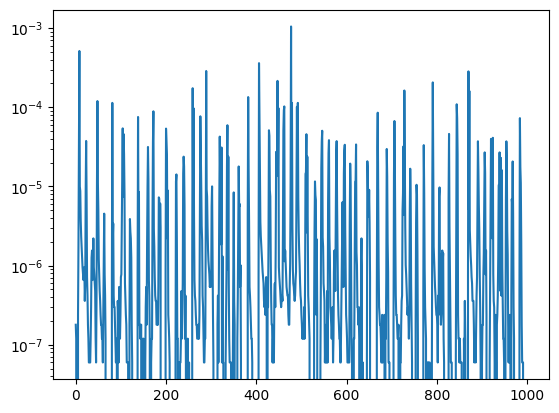

In [155]:
n_epochs = 1000  # number of epochs to run
batch_size = 2  # size of each batch
batches_per_epoch = len(X) // batch_size

losses = []
loss_hist = None
for epoch in (pbar := tqdm(range(n_epochs))):
    loss_cnt = 0
    for i in range(batches_per_epoch):
        optimizer.zero_grad()

        start = i * batch_size
        # take a batch
        Xbatch = X[start:start + batch_size]
        ybatch = y[start:start + batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()

        loss_cnt += loss
    losses.append(loss_cnt.item())
    loss_hist = loss_hist * 0.75 + losses[-1] * 0.25 if loss_hist else losses[-1]
    if epoch % 10 == 0:
        pbar.set_description(f"loss = {loss_hist:.5f}")

plt.semilogy(losses)
print(f"Accuracy: {(model(X).argmax(-1) == y).float().mean().item()}")

Accuracy: 1.0


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

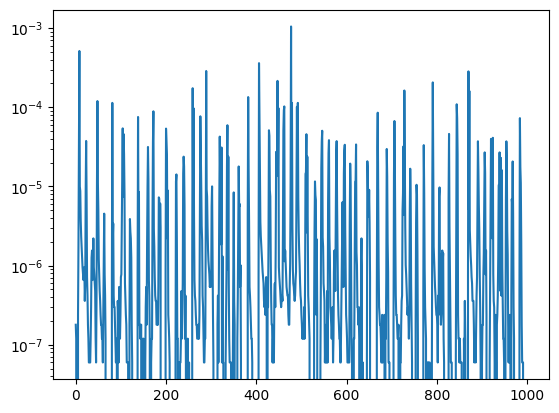

In [156]:
plt.semilogy(losses)
print(f"Accuracy: {(model(X).argmax(-1) == y).float().mean().item()}")
model(X).argmax(-1)

In [157]:
model

MLP(
  (lin): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=5, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
    )
    (1): Sequential(
      (0): Linear(in_features=5, out_features=10, bias=True)
    )
  )
)

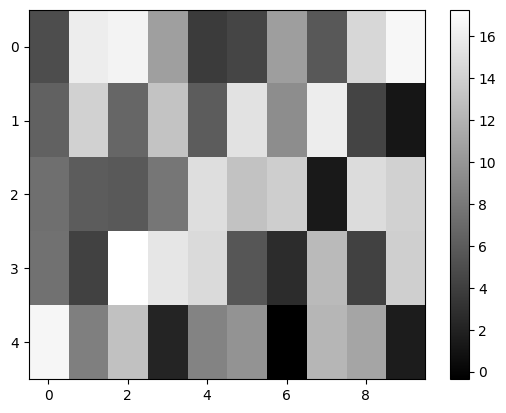

In [158]:
plt.imshow(model.lin[0][0].state_dict()['weight'].cpu().detach().numpy(), aspect='auto', cmap="gray")
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

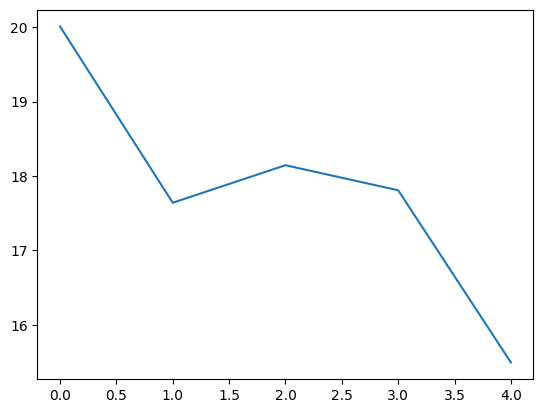

In [154]:
plt.plot(model.lin[0][0].state_dict()['bias'].cpu().detach().numpy())
plt.colorbar()